# Retention Scoring - PROD - Redshift - Canucks data
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* July 14, 2022

## Hypothesis
This notebook will test the retention model features and the goal is to check how the accuracy and scores look when we train the model only with Canucks data compared to all NHL data.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [125]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from pandas_profiling import ProfileReport
from shared_utilities import helpers
from pycaret.classification import *

In [126]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

MKJC-JVTS
Successully logged into Start URL: https://stellaralgo.awsapps.com/start#/


In [127]:
conn = helpers.get_redshift_connection('prod-app', 'stlrcanucks')

In [128]:
# call the stored proc to get data for the retention model
cur = conn.cursor()
cur.execute(f"CALL ds.getretentionmodeldata(7,2010, 2022, 'temp_cursor')")

# create a named cursor based on the cursor name passed in above
named_cursor = conn.cursor('temp_cursor')
data = named_cursor.fetchall()

# load the data and columns into a data frame
cols = [row[0] for row in named_cursor.description]
df = pd.DataFrame(data=data, columns=cols)

conn.commit()

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32937 entries, 0 to 32936
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   lkupclientid         32937 non-null  int64         
 1   dimcustomermasterid  32937 non-null  int64         
 2   year                 32937 non-null  int64         
 3   productgrouping      32937 non-null  object        
 4   totalspent           32937 non-null  float64       
 5   recentdate           32937 non-null  datetime64[ns]
 6   attendancepercent    32937 non-null  float64       
 7   renewedbeforedays    32937 non-null  int64         
 8   source_tenure        32937 non-null  object        
 9   tenure               32937 non-null  int64         
 10  disttovenue          32937 non-null  float64       
 11  recency              32937 non-null  int64         
 12  missed_games_1       32937 non-null  object        
 13  missed_games_2       32937 non-

In [130]:
df["year"].unique()

array([2016, 2021, 2018, 2019, 2017, 2015])

In [131]:
# choose the features for the stellar base retention model
features = [
    "lkupclientid",
    "dimcustomermasterid",
    "year", 
    "productgrouping",
    "recentdate",
    "attendancepercent",
    "recency",
    "source_tenure",
    "totalspent",
    "isnextyear_buyer"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2020]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (23625, 10)
Unseen Data For Predictions: (4169, 10)



In [132]:
setup(
    data= df_train, 
    target="isnextyear_buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=[
        "dimcustomermasterid",
        "lkupclientid",
        "productgrouping",
        "year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancepercent",
        "recency",
        "source_tenure",
        "totalspent"
    ]
);

In [133]:
model_matrix = compare_models(
    fold=10,
    include=["xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8091,0.8864,0.8432,0.7994,0.8207,0.6168,0.6181,1.2280


In [134]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8019,0.8822,0.8252,0.7991,0.8119,0.6028,0.6031
1,0.8053,0.8855,0.8317,0.8002,0.8157,0.6095,0.6100
2,0.8003,0.8766,0.8183,0.8006,0.8093,0.5998,0.5999
3,0.8103,0.8828,0.8356,0.8054,0.8202,0.6195,0.6200
4,0.8152,0.8903,0.8490,0.8049,0.8264,0.6292,0.6303
5,0.8127,0.8889,0.8654,0.7923,0.8272,0.6237,0.6266
6,0.8008,0.8877,0.8559,0.7809,0.8167,0.5996,0.6026
7,0.8123,0.8822,0.8549,0.7975,0.8252,0.6230,0.6247
8,0.8197,0.8976,0.8501,0.8112,0.8302,0.6383,0.6391
9,0.8123,0.8901,0.8463,0.8024,0.8237,0.6232,0.6242


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

In [135]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(5143, 23)

In [136]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupclientid,dimcustomermasterid,year,productgrouping,totalspent,recentdate,attendancepercent,renewedbeforedays,source_tenure,tenure,...,opentosendratio,clicktosendratio,clicktoopenratio,gender,phonecall,inperson_contact,isnextyear_buyer,Label,Score_0,Score_1
1,7,8828,2021,Full Season,505.0,2022-04-28,2.00,0,1460,946,...,0.34,0.23,0.67,Unknown,0,0,0,0,0.9815,0.0185
4,7,9046,2021,Full Season,12330.8,1970-01-01,0.00,95,730,302,...,0.88,0.00,0.00,Unknown,0,0,1,0,0.9988,0.0012
5,7,11878,2021,Full Season,13266.9,2022-04-03,0.09,102,11315,2435,...,3.53,0.13,0.04,Unknown,0,0,1,1,0.0964,0.9036
7,7,6018,2021,Full Season,5820.5,2022-04-14,0.14,102,1825,1694,...,3.84,0.04,0.01,Unknown,0,0,1,0,0.6867,0.3133
8,7,18902,2021,Quarter,511.7,2022-04-14,1.00,20,1095,771,...,1.21,0.11,0.09,Unknown,0,0,0,0,0.9959,0.0041


In [137]:
new_predictions["Label"].value_counts()

0    2621
1    2522
Name: Label, dtype: int64

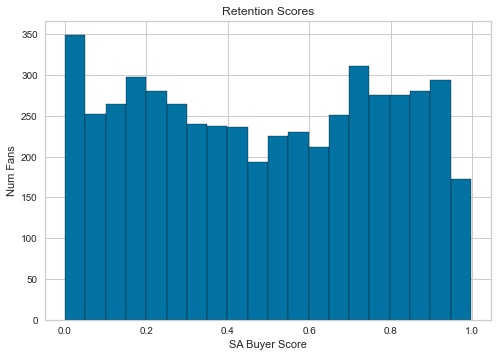

In [138]:
plt.hist(new_predictions["Score_1"], bins=20, edgecolor='black')
plt.title("Retention Scores")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.show()

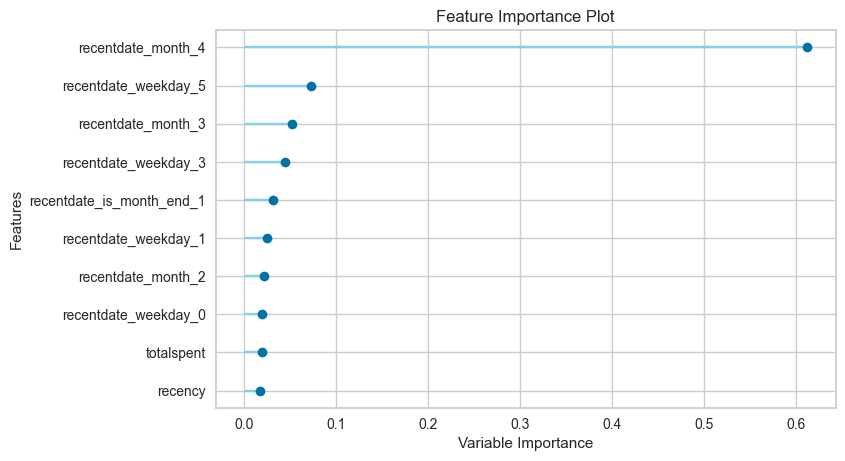

In [139]:
plot_model(final_model, plot='feature')

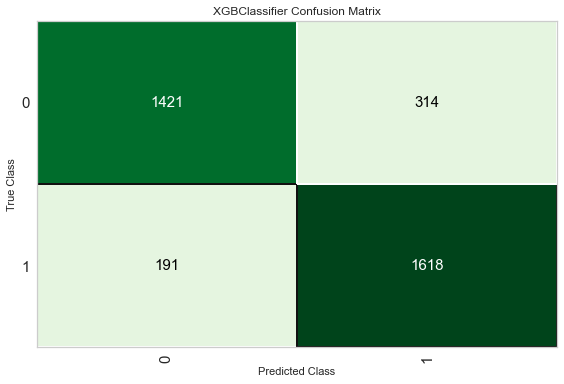

In [140]:
plot_model(final_model, plot='confusion_matrix')

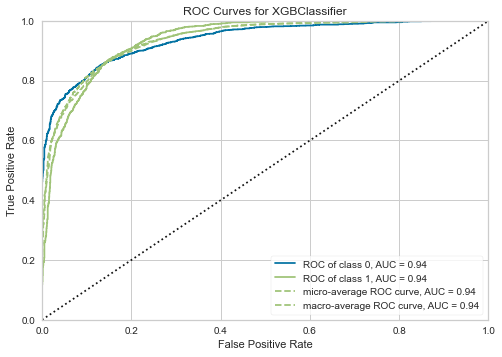

In [141]:
plot_model(final_model, plot='auc')

In [142]:
report = ProfileReport(new_predictions)
#report
report.to_file("canucks_data_retention_predictions.html")

Summarize dataset:   0%|          | 0/40 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [143]:
report2 = ProfileReport(df)
report2.to_file("canucks_data_retention_df.html")

Summarize dataset:   0%|          | 0/36 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Observations for using Canucks data

1. How accurate was this model? 
* The accuracy is 81% (3% lower than using all NHL data)

2. How many fans will buy ticket for 2022 season?
* 2571 fans out of 5143 (676 fans lower than using all NHL data)

3. What were the most important features in making a correct prediction?
* recentdate_month_4, recentdate_weekday_5, recentdate_month_3 are top 3 important features.


### Done